In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
tf.config.set_visible_devices([], 'GPU')

from tensorflow import keras

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

import sklearn
# import randomfrom numpy import *
from PIL import Image
# import theano
import pandas as pd

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8380827405938791567
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5731516416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6398414949807002652
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


Found 361 files belonging to 5 classes.
Using 289 files for training.
Found 361 files belonging to 5 classes.
Using 72 files for validation.


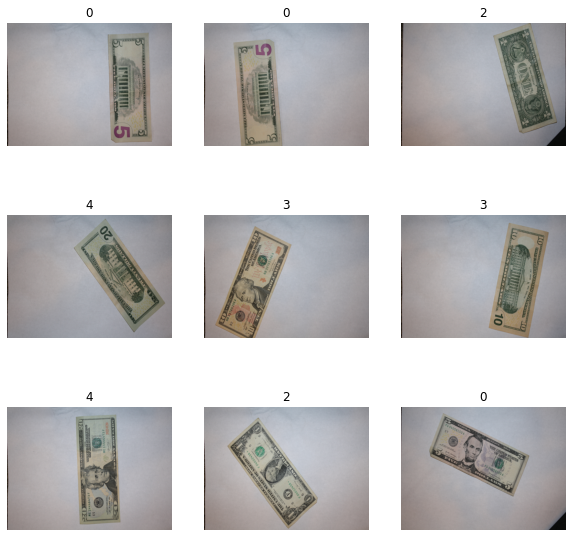

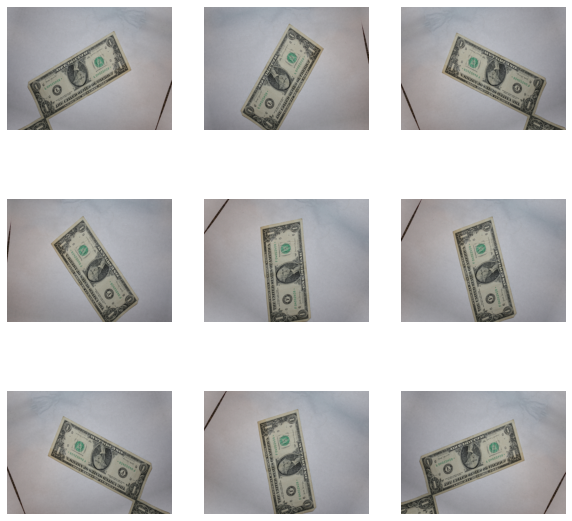

In [5]:
path_train = "train_img"

IMG_SIZE = (768, 1024)
# IMG_SIZE = (480, 640)
# IMG_SIZE = (288, 352)

CATEGORIES = ["ONE", "TWO", "TEN", "TWENTY", "FIFTY", "HUNDRED"]

# load train dataset from folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_img",
    # color_mode='grayscale',
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="training",
    seed=123
)

# load validation dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_img",
    # color_mode='grayscale',
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=123
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# create the augmented train data set
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))


In [6]:
model = keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(IMG_SIZE[0],IMG_SIZE[1],3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

pretrained_model.trainable = False

pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 774, 1030, 3  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 384, 512, 64  9472        ['conv1_pad[0][0]']              
                                )                                                          

In [7]:
model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
# compiling the model
tf.keras.backend.clear_session()
model.compile(loss = "sparse_categorical_crossentropy",
optimizer = "adam",
metrics = ["accuracy"])

In [10]:
tf.keras.backend.clear_session()
history = model.fit(augmented_train_ds,
                    epochs = 15,
                    batch_size = 16,
                    validation_data = test_ds)

Epoch 1/15
10/10 [==============================] - 209s 21s/step - loss: 1.6228 - accuracy: 0.4360 - val_loss: 0.9719 - val_accuracy: 0.6389
Epoch 2/15
10/10 [==============================] - 206s 21s/step - loss: 1.0248 - accuracy: 0.6367 - val_loss: 0.5753 - val_accuracy: 0.8889
Epoch 3/15
10/10 [==============================] - 206s 21s/step - loss: 0.5978 - accuracy: 0.7751 - val_loss: 0.4383 - val_accuracy: 0.9306
Epoch 4/15
10/10 [==============================] - 208s 21s/step - loss: 0.4197 - accuracy: 0.9031 - val_loss: 0.2968 - val_accuracy: 0.9306
Epoch 5/15
10/10 [==============================] - 209s 21s/step - loss: 0.4304 - accuracy: 0.8235 - val_loss: 0.4288 - val_accuracy: 0.8056
Epoch 6/15
10/10 [==============================] - 210s 21s/step - loss: 0.3473 - accuracy: 0.8685 - val_loss: 0.1905 - val_accuracy: 0.9444
Epoch 7/15
10/10 [==============================] - 212s 21s/step - loss: 0.1786 - accuracy: 0.9792 - val_loss: 0.2165 - val_accuracy: 0.9583
Epoch 

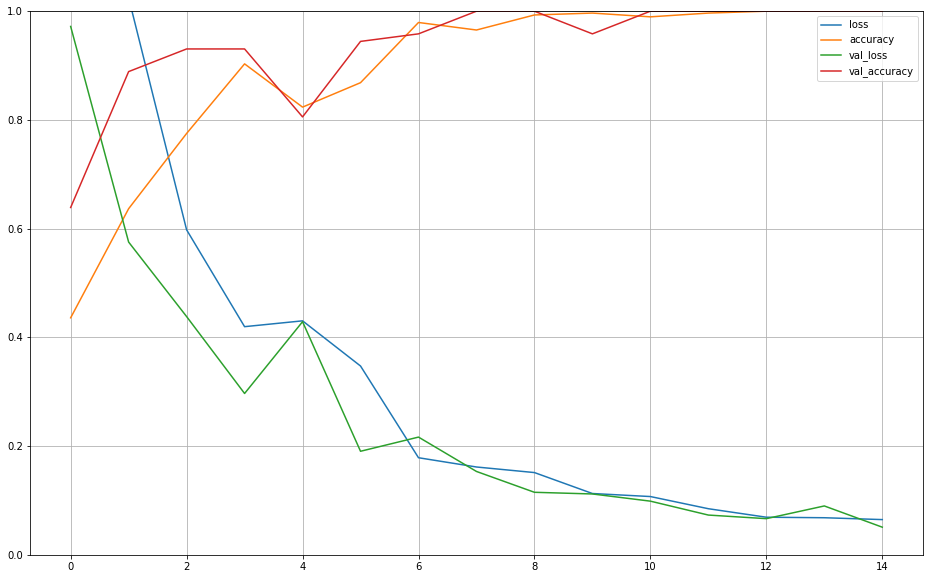

In [11]:
pd.DataFrame(history.history).plot(figsize = (16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
model.evaluate(test_ds)
model.save("completed_model")

3/3 [==============================] - 39s 11s/step - loss: 0.0508 - accuracy: 1.0000
INFO:tensorflow:Assets written to: completed_model\assets


In [13]:
# model_test = keras.models.load_model('completed_model')
# model_test.evaluate(test_ds)

In [14]:
# Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.representative_dataset = representative_dataset
# converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\justi\AppData\Local\Temp\tmpqxrnhqss\assets


INFO:tensorflow:Assets written to: C:\Users\justi\AppData\Local\Temp\tmpqxrnhqss\assets
